In [1]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

import numpy as np
from tqdm import tqdm
from spectralETD import spectralETD

# 1D Advection-Diffusion Equation

The one-dimensional advection-diffusion equation is written as

$$ \frac{\partial \eta}{\partial t} = - u\frac{\partial \eta}{\partial x} + D \frac{\partial^2 \eta}{\partial x^2}$$
with $u$ being the velocity constant, $D$ being the diffusion coefficient, and $\eta$ represents the concentration field. The time derivative of the Fourier Transform $\widetilde{\eta}_{k}$ is 
$$\frac{\partial }{\partial t}\widetilde{\eta}_{k}(t) = -(i u k + D k^2)\widetilde{\eta}_{k}(t)$$
This case corresponds to the pseudo-spectral equation 
$$ \frac{\partial \widetilde{\eta}_{k}}{\partial t} = \widetilde{\mathcal{L}}_{k} \widetilde{\eta}_{k} + \widetilde{\mathcal{N}}_{k} (\eta(t))$$
 with the following operators given by 
$$\widetilde{\mathcal{L}}_{k} = -(i u k + D k^2), \quad \text{and} \quad \widetilde{\mathcal{N}}_{k} = 0$$
such that the time evolution has an analytical solution in the form
$$\widetilde{\eta}_{k}(t) = \widetilde{\eta}_{k}(0) e^{-(i u k + D k^2) t}$$

As an example, we set $u = 5$ and $D=0.01$. The size of the system is $L=2\pi$ with the number of gridpoints $N=2^{12} = 4096$. The initial profile is a top-hat function with length of $l=0.2$ and intensity of $\eta_0 = 1.0$ starting at $x_0 = -\pi$.

In [2]:
# diffusion-advection constants
D = 0.01
u = 5.0

In [3]:
DA = spectralETD(ndim=1,method='ETD',device='cuda')

In [4]:
L = 2*np.pi
dx = L/4096
DA.Set_Geometry(lengths=(L,),gridsize=(dx,))
x = DA.x

In [5]:
# The linear terms of PDE
def Loperator_k(params):
    u,D,Kx,K2 = params
    return -1.0j*Kx*u-D*K2

params = u,D,DA.Kx,DA.K2
DA.Set_LinearOperator(Loperator_k,params)

In [6]:
# The non-linear terms of PDE (with dealising)
DA.Set_NonLinearOperator(None,params)

In [7]:
DA.Set_TimeStep(h=0.01)

In [8]:
# Frames to the output
dt = 0.1
T = 1.0
t = np.arange(0.0,T,dt)
Nsteps = t.size

In [9]:
# The tensor of outputs on cpu
n = np.empty((Nsteps,DA.Ngrid[0])) 

# Setting Initial condition
n[0] = 0.0
l = int(0.2/dx)
n[0][:l] = 1.0 

DA.Set_Field(n[0])

In [10]:
# time evolution loop
for i in tqdm(range(1,Nsteps)):
    n[i] = DA.Calculate_Dynamics(t[i-1],t[i])

100%|██████████| 9/9 [00:00<00:00, 91.50it/s]


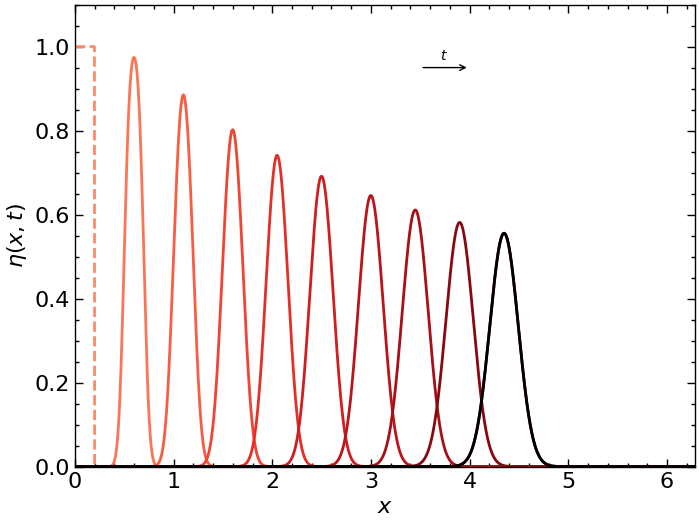

In [12]:
fig, ax = plt.subplots(1,1)

my_map = plt.get_cmap('Reds')
color = my_map(np.linspace(0.4,1.0,Nsteps))
plt.plot(x,n[0],'--',color=color[0])
for i in range(1,Nsteps):
    plt.plot(x,n[i],'-',color=color[i])
plt.plot(x,n[-1],'-k')
plt.xlabel(r'$x$')
plt.ylabel(r'$\eta(x,t)$')
plt.annotate("", xy=(4, 0.95), xytext=(3.5, 0.95),
            arrowprops=dict(arrowstyle="->"))
plt.text(3.7,0.97,r"$t$")
plt.xlim(0.0,2*np.pi)
plt.ylim(0.,1.1)
fig.savefig('diffusion_advection.pdf')

# Generating a MP4 video

In [13]:
from matplotlib import animation

my_map = plt.get_cmap('Reds')
color = my_map(np.linspace(0.4,1.0,Nsteps))
def animate(i):
    ax.clear()
    for j in range(i+1):
        ax.plot(x,n[j],'-',color=color[j])
    ax.plot(x,n[i],'-k')
    ax.text(0.0,0.97,r'$t={:.2f}$'.format(i*dt))
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\eta(x,t)$')
    return fig,
    
fig, ax = plt.subplots(1,1,figsize=(4,3))
ani = animation.FuncAnimation(fig, animate, frames= Nsteps,
                               interval = 50)
writervideo = animation.FFMpegWriter(fps=100) 
ani.save('diffusion_advection.mp4',writer=writervideo,dpi=200)

<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_120424/1249097257.py:12: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel('$\eta(x,t)$')
/tmp/ipykernel_120424/1249097257.py:12: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel('$\eta(x,t)$')


AttributeError: module 'matplotlib.cm' has no attribute 'get_cmap'